### 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("Main Workflow - 모듈화 TEST")

LangSmith 추적을 시작합니다.
[프로젝트명]
Main Workflow - 모듈화 TEST


### LLM

In [4]:
from agents import *
from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs

# LLM 초기화
MODEL_NAME = get_model_name(LLMs.GPT4o)
llm = ChatOpenAI(temperature=0, model=MODEL_NAME)

# DiaryEntry 구조체와 suggest_keywords_tool을 바인딩
llm_with_tool = llm.bind_tools([DiaryEntry, suggest_keywords_tool])

### 그래프 생성

In [5]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 메모리에 대화 기록을 저장하기 위한 MemorySaver 초기화
memory = MemorySaver()

# 상태 그래프 초기화
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("info", InfoNode(llm_with_tool))
workflow.add_node("suggest_keywords_message", SuggestKeywordsNode())
workflow.add_node("create_entry", CreateEntryNode())
workflow.add_node("generate_diary_body", GenerateDiaryBodyNode(llm))
workflow.add_node("generate_emotion_charts", GenerateEmotionChartsNode())
workflow.add_node("generate_diary", GenerateDiaryNode())


# 조건부 상태 전환 정의
workflow.add_conditional_edges(
    "info",
    RouterNode(),
    ["suggest_keywords_message", "create_entry", "generate_diary_body", "info", END],
)

# 엣지 정의
workflow.add_edge("suggest_keywords_message", "info")
workflow.add_edge("create_entry", "info")
workflow.add_edge("generate_diary_body", "generate_emotion_charts")
workflow.add_edge("generate_emotion_charts", "generate_diary")
workflow.add_edge("generate_diary", END)
workflow.add_edge(START, "info")

# 그래프 컴파일
main_graph = workflow.compile(checkpointer=memory)

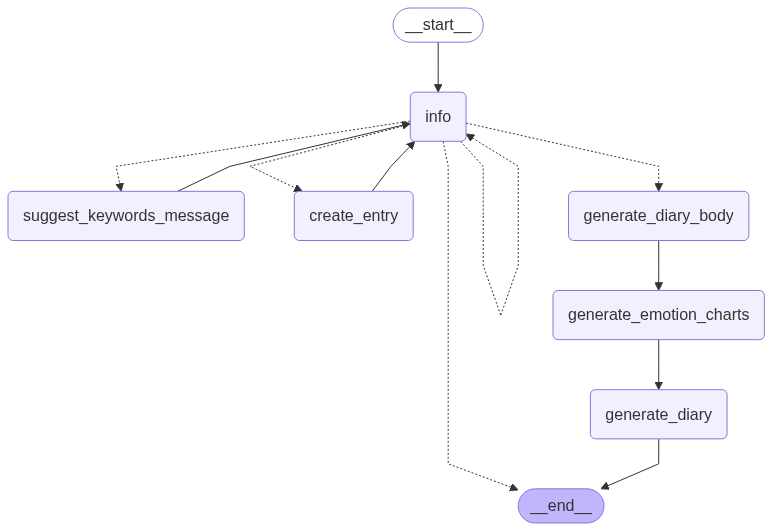

In [6]:
from IPython.display import Image, display

display(Image(main_graph.get_graph().draw_mermaid_png()))

In [8]:
import uuid
from datetime import date, datetime
from langchain_core.messages import HumanMessage
from langchain_teddynote.messages import stream_graph

# 구성 설정 초기화 (고유한 thread_id 생성)
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# 무한 루프 시작
while True:
    try:
        # 사용자 입력 받기
        user = input("User (e/E to quit): ")
    except:
        pass

    # 사용자 입력 출력
    print(f"\n\033[93m[사용자] {user}\033[0m")

    # 'q' 또는 'Q' 입력 시 루프 종료
    if user in {"e", "E"}:
        print("AI: 다음에 또 보자!")
        break

    # 출력 변수 초기화
    output = None

    stream_graph(
        main_graph,
        {
            "messages": [HumanMessage(content=user)],
            "user_name": "예리",
            "today_date": date.today(),
            "written_at": datetime.now().time(),
        },
        config=config,
        node_names=[
            "info",
            "suggest_keywords_message",
            "create_entry",
            "generate_diary_body",
            "generate_emotion_charts" "generate_diary",
        ],
    )


[사용자] 안녕!

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕! 오늘 하루 어땠어? 특별한 일 있었어? 😊
[사용자] 오늘 오랜만에 아침 조깅을 했어

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
아침 조깅이라니 상쾌했겠다! 그럼 이 사건을 "아침 조깅"이라고 제목을 붙일 수 있을까? 그리고 몇 시쯤에 조깅했는지 알려줄 수 있어?
[사용자] 아침 6시 정도에 했어

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
좋아, 아침 6시에 조깅을 했구나! 그때 느꼈던 감정을 하나 선택해줄래? ["기쁨", "설렘", "평범함", "놀라움", "불쾌함", "두려움", "슬픔", "분노"] 중에서 골라줘.
[사용자] 기쁨

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: suggest_keywords_message 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
<RAW>추천된 감정 키워드는 다음과 같아: 
[기분좋은, 즐거운, 고마운, 홀가분한, 사랑스러운, 재밌는, 기쁜, 뿌듯한, 속시원한, 만족스러운, 신나는, 행복한, 감동받은, 날아갈 것 같은] 
이 중에서 1~3개를 골라줘.</RAW>
🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
추천된 감정 키워드는 다음과 같아: 
[기분좋은, 즐거운, 고마운, 홀가분한, 사랑스러운, 재밌는, 기쁜, 뿌듯한, 속시원한, 만족스러운, 신나는, 행복한, 감동받은, 날아갈 것 같은] 
이 중에서 1~3개를 골라줘.
[사용자] 기분좋은, 홀가분한, 신나는

🔄 Node: info 🔄
- - - - - - - - 

In [9]:
# 그래프 상태 스냅샷 생성
snapshot = main_graph.get_state(config)
test_markdown = snapshot.values["final_markdown"]

In [10]:
from IPython.display import Markdown

display(Markdown(test_markdown))

# 📘 2025년 08월 18일 일기
> ⏰ 작성 시각: 01:38

## ☀️ 오늘의 한 줄
> 햇살 가득한 아침 조깅으로 시작해 긴장된 발표를 잘 마무리하고, 포근한 첫눈에 설렘을 느낀 하루였어.

---

## 📋 오늘의 사건 요약

| 시간대 | 사건명 | 감정 | 감정 키워드 | 함께한 사람 |
|--------|--------|------|--------------|---------------|
| 오전 6시 | 아침 조깅 | 기쁨 | 기분좋은, 홀가분한, 신나는 | 혼자 |
| 오후 2시 30분 | 프로젝트 발표 | 두려움 | 긴장되는 | 유재석(동료) |
| 오후 8시 | 첫눈 | 설렘 | 몽글몽글한, 두근거리는, 설레는 | 혼자 |

---

## 📖 오늘의 일기

오늘 아침, 오랜만에 조깅을 나갔다. 아침 햇살이 너무 예뻐서 기분이 좋았고, 선선한 바람이 불어와 마음이 홀가분했다. 몸이 가볍고 마음이 맑아지는 기분이었고, 아침 시간을 나를 위해 쓴 것 같아 뿌듯했다. 하지만 운동화를 바꿔야 할 것 같다. 발이 살짝 아팠기 때문이다. 그래도 햇살 가득한 아침 조깅으로 상쾌한 하루를 시작할 수 있었다.

오후에는 프로젝트 발표가 있었다. 발표 전에는 심장이 너무 뛰어서 손까지 떨렸지만, 막상 말하기 시작하니 긴장이 점점 풀렸다. 준비했던 내용을 자연스럽게 전달할 수 있었고, 많이 떨렸지만 결국 잘 해내서 다행이었다. 진심을 담은 설명은 꼭 완벽하지 않아도 전달된다는 것을 느꼈다. 많이 긴장했지만, 회사 발표를 잘 마무리할 수 있었다.

저녁에는 첫눈이 내렸다. 첫눈을 보면 항상 기분이 좋아진다. 코끝도, 손도, 발도 시렸지만 마음은 포근했다. 바쁘게 흘러가는 일상 속에서 잠깐 멈춰서 첫눈을 즐기며 마음을 느낄 수 있었다. 오늘 하루는 이렇게 다양한 감정들로 가득 찼다. 기쁨, 두려움, 설렘이 어우러진 하루였다.

---

## 📊 감정 요약 그래프

### 🥧 감정 비율
![감정 비율](C:\Users\user\HowRU_AI_test\emotion_charts\pie_20250818_c3ef2c889f604fdeb5af9dedd47fb787.png)

### 📈 시간 흐름에 따른 감정 변화
![감정 흐름](C:\Users\user\HowRU_AI_test\emotion_charts\flow_20250818_523e41024e3d495cb6da000a04486411.png)

### 🎯 감정 점수 추이
![감정 점수](C:\Users\user\HowRU_AI_test\emotion_charts\score_20250818_36a5e43e18f847c6abe67a9f3829e404.png)
